In [1]:
import os
from av2.datasets.sensor.av2_sensor_dataloader import  AV2SensorDataLoader
from pathlib import Path
from av2.structures.sweep import Sweep

dataset_path = Path(os.path.join(os.path.expanduser("~"), 'buni', 'dataset','av2-pixor','overfit','train'))

av2 = AV2SensorDataLoader(data_dir=dataset_path, labels_dir=dataset_path)

scene_id = av2.get_log_ids()[0]
frame_path = av2.get_ordered_log_lidar_fpaths(scene_id)[0]

sweep = Sweep.from_feather(frame_path)

points = sweep.xyz

timetstamp = sweep.timestamp_ns
import os
import pandas as pd

home = os.path.expanduser("~")
label_path = os.path.join(home,'buni','output-data','av2','bbox-estimation',scene_id,str(timetstamp))
label_df = pd.read_feather((label_path+".feather"))

In [2]:
from typing import Tuple
import numpy as np
def filter_points_in_ROI(points: np.ndarray,x_range: Tuple[int, int], y_range: Tuple[int, int]) -> Tuple[np.ndarray, np.ndarray]:
    """
    Filter out points and corresponding beam IDs that are not in the region of interest (ROI).
    
    Parameters:
        points: np.ndarray
        beam_ids: np.ndarray
        x_range: Tuple[int, int]  # Range of x values (longitudinal axis)
        y_range: Tuple[int, int]  # Range of y values (lateral axis)
        
    Returns:
        Tuple of filtered points and corresponding beam IDs in the region of interest.
    """
    # Define the ROI boundaries
    x_min, x_max = x_range[0], x_range[1]   # Longitudinal (x-axis)
    y_min, y_max = y_range[0], y_range[1]   # Lateral (y-axis)

    # Apply the conditions to filter the points within the ROI
    in_roi = (points[:, 0] >= x_min) & (points[:, 0] <= x_max) & \
            (points[:, 1] >= y_min) & (points[:, 1] <= y_max)
        
    # Use the conditions to index the original points and beam IDs arrays
    filtered_points = points[in_roi]

    return filtered_points

x_range=[0,70]
y_range=[-40,40]

points_roi = filter_points_in_ROI(points, x_range, y_range)

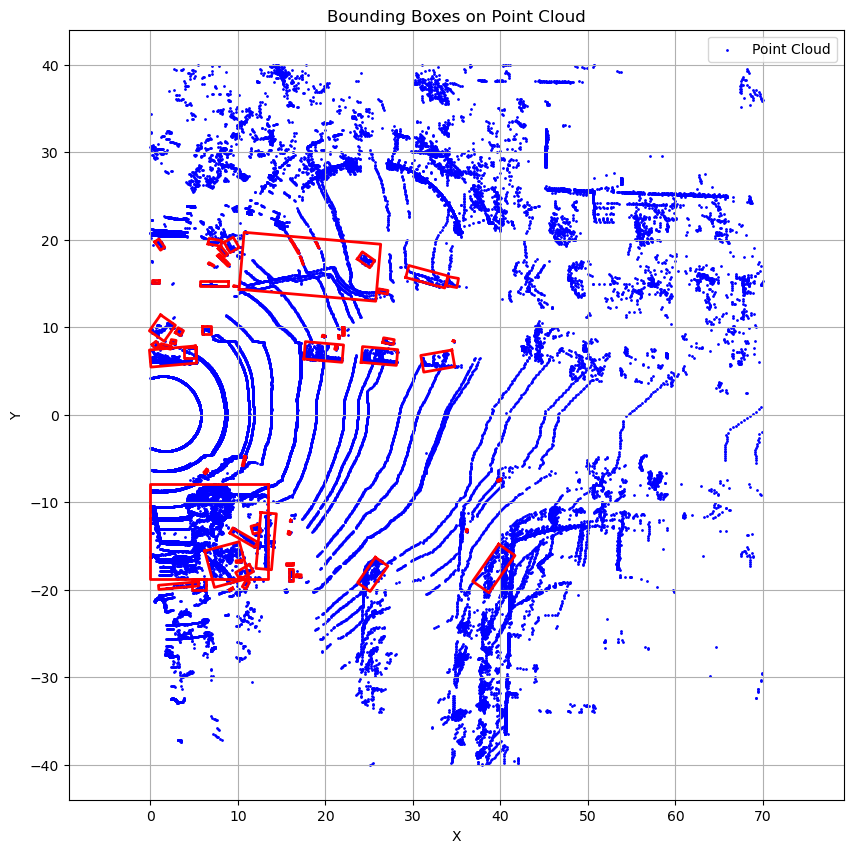

In [3]:
import numpy as np
import matplotlib.pyplot as plt

def get_bbox_corners(label_df):
    """
    Calculate the four corners of each bounding box in the dataframe.

    Parameters:
    - label_df: DataFrame containing bounding box parameters:
      ['box_center_x', 'box_center_y', 'box_length', 'box_width', 'ry']

    Returns:
    - corners: List of arrays, each containing the four (x, y) corner coordinates for a bounding box.
    """
    corners = []
    
    for _, row in label_df.iterrows():
        cx, cy = row['box_center_x'], row['box_center_y']
        length, width = row['box_length'], row['box_width']
        ry = row['ry']
        
        # Half-dimensions
        half_length = length / 2
        half_width = width / 2
        
        # Rotation matrix for the bounding box orientation
        rotation_matrix = np.array([
            [np.cos(ry), -np.sin(ry)],
            [np.sin(ry),  np.cos(ry)]
        ])
        
        # Define the four corners in the local frame
        local_corners = np.array([
            [ half_length,  half_width],
            [ half_length, -half_width],
            [-half_length, -half_width],
            [-half_length,  half_width]
        ])
        
        # Rotate and translate the corners to the global frame
        global_corners = (rotation_matrix @ local_corners.T).T + np.array([cx, cy])
        
        # Append the corners for this bbox
        corners.append(global_corners)
    
    return corners

def plot_bboxes_on_point_cloud(label_df, points_roi):
    """
    Visualize bounding boxes on a point cloud using matplotlib.

    Parameters:
    - label_df: DataFrame containing bounding box parameters.
    - points_roi: Nx3 array representing the point cloud data in [x, y, z] format.
    """
    # Get the x and y points for the point cloud visualization
    x_points = points_roi[:, 0]
    y_points = points_roi[:, 1]
    
    # Plot point cloud
    plt.figure(figsize=(10, 10))
    plt.scatter(x_points, y_points, s=1, color='blue', label='Point Cloud')
    
    # Plot each bounding box
    corners = get_bbox_corners(label_df)
    for bbox_corners in corners:
        # Close the box by repeating the first corner at the end
        bbox_corners = np.vstack((bbox_corners, bbox_corners[0]))
        plt.plot(bbox_corners[:, 0], bbox_corners[:, 1], color='red', linewidth=2)
    
    # Plot settings
    plt.xlabel("X")
    plt.ylabel("Y")
    plt.title("Bounding Boxes on Point Cloud")
    plt.axis('equal')
    plt.legend()
    plt.grid(True)
    plt.show()
    


# Example usage:
# Assuming label_df is your dataframe and points_roi is your point cloud data
plot_bboxes_on_point_cloud(label_df, points_roi)

In [ ]:
from typing import List, Tuple
import numpy as np

def get_bbox_params(corners: np.ndarray) -> List:
    """
    Extract bbox parameters from corner coordinates.
    
    Args:
        corners: numpy array of shape (4,2) containing x,y coordinates
    
    Returns:
        tuple: (cx, cy, length, width, orientation)
    """
    import numpy as np
    
    # Calculate centroid
    cx = np.mean(corners[:, 0])
    cy = np.mean(corners[:, 1])
    
    # Calculate orientation
    edge = corners[3] - corners[0]
    orientation = np.arctan2(edge[1], edge[0])
    
    # Calculate length (distance between corners 0 and 1)
    length = np.linalg.norm(corners[1] - corners[0])
    
    # Calculate width (distance between corners 0 and 3)
    width = np.linalg.norm(corners[3] - corners[0])
    
    return [cx, cy, length, width, orientation]


def get_corners_debug(bbox: List[float]) -> Tuple[np.ndarray, np.ndarray]:
    """
    return the 4 corners of the bounding box in the bird's eye view
    
    Args:
        bbox:  list of the bounding box parameters of shape (5)
    
    Returns:
        bev_corners: [4 * 2] numpy array of the 4 corners' (x, y)
        reg_target: [6] numpy array of the regression targets  
    """
    x, y, l, w, yaw = bbox
    
    # w, h, l, y, z, x, yaw = bbox[8:15]
    # manually take a negative s. t. it's a right-hand system, with
    # x facing in the front windshield of the car
    # z facing up
    # y facing to the left of driver

    # yaw = -(yaw + np.pi / 2)
    
    
    bev_corners = np.zeros((4, 2), dtype=np.float32)
    # rear left
    bev_corners[0, 0] = x - l/2 * np.cos(yaw) - w/2 * np.sin(yaw)
    bev_corners[0, 1] = y - l/2 * np.sin(yaw) + w/2 * np.cos(yaw)

    # rear right
    bev_corners[1, 0] = x - l/2 * np.cos(yaw) + w/2 * np.sin(yaw)
    bev_corners[1, 1] = y - l/2 * np.sin(yaw) - w/2 * np.cos(yaw)

    # front right
    bev_corners[2, 0] = x + l/2 * np.cos(yaw) + w/2 * np.sin(yaw)
    bev_corners[2, 1] = y + l/2 * np.sin(yaw) - w/2 * np.cos(yaw)

    # front left
    bev_corners[3, 0] = x + l/2 * np.cos(yaw) - w/2 * np.sin(yaw)
    bev_corners[3, 1] = y + l/2 * np.sin(yaw) + w/2 * np.cos(yaw)

    reg_target = [np.cos(yaw), np.sin(yaw), x, y, w, l]

    return bev_corners, reg_target

def get_orientation(corners: np.ndarray):
    edge = corners[3] - corners[0]
    orientation = np.arctan2(edge[1], edge[0])
    if orientation < 0:
        orientation += np.pi
    return orientation

In [ ]:
test_idx = 1 # 5
pixor_corners, _ = get_corners_debug(label_df.iloc[test_idx].to_list()) # a numpy array of shape 4x2
av2_corners = get_bbox_corners(label_df)[test_idx] # a numpy array of shape 4x2

In [ ]:
print(label_df.iloc[test_idx])
print(f"av2_params: {get_bbox_params(av2_corners)}")
print(f"pixor_params: {get_bbox_params(pixor_corners)}")

In [ ]:
print(f"av2_orientation: {get_orientation(av2_corners)}")
print(f"pixor_orientation: {get_orientation(pixor_corners)}")

In [ ]:
print(np.rad2deg(label_df.iloc[test_idx]['ry']))
print(np.rad2deg(get_bbox_params(av2_corners)[4]))
print(np.rad2deg(get_bbox_params(pixor_corners)[4]))

In [ ]:
def plot_single_box(bbox, points_roi):
    """
    Visualize bounding boxes on a point cloud using matplotlib.

    Parameters:
    - label_df: DataFrame containing bounding box parameters.
    - points_roi: Nx3 array representing the point cloud data in [x, y, z] format.
    """
    # Get the x and y points for the point cloud visualization
    x_points = points_roi[:, 0]
    y_points = points_roi[:, 1]
    
    # Plot point cloud
    plt.figure(figsize=(10, 10))
    plt.scatter(x_points, y_points, s=1, color='blue', label='Point Cloud')
    
    # Plot each bounding box
    corners = bbox
    for bbox_corners in corners:
        # Close the box by repeating the first corner at the end
        bbox_corners = np.vstack((bbox_corners, bbox_corners[0]))
        plt.plot(bbox_corners[:, 0], bbox_corners[:, 1], color='red', linewidth=2)
    
    # Plot settings
    plt.xlabel("X")
    plt.ylabel("Y")
    plt.title("Bounding Boxes on Point Cloud")
    plt.axis('equal')
    plt.legend()
    plt.grid(True)
    plt.show()
    
# plot_single_box([av2_corners], points_roi)
# plot_single_box([pixor_corners], points_roi)

In [ ]:
def visualize_corners_colored(points, bbox_corners,title, fig_size=(10,10)):
    """
    Visualize bbox corners with different colors overlaid on point cloud.
    
    Args:
        points: numpy array of shape (N,2) containing point cloud x,y coordinates
        bbox_corners: numpy array of shape (4,2) containing corner coordinates
        fig_size: tuple, figure size
    """
    import matplotlib.pyplot as plt
    import numpy as np
    
    # Define colors for each corner
    colors = ['red', 'blue', 'green', 'orange']
    corner_names = ['Corner 0', 'Corner 1', 'Corner 2', 'Corner 3']
    
    plt.figure(figsize=fig_size)
    
    # Plot point cloud
    plt.scatter(points[:, 0], points[:, 1], s=1, c='gray', alpha=0.5, label='Point Cloud')
    
    # Plot each corner with different color
    for i in range(4):
        plt.scatter(bbox_corners[i, 0], bbox_corners[i, 1], 
                   c=colors[i], s=100, marker='x', 
                   label=corner_names[i], linewidth=2)
    
    plt.xlabel('X')
    plt.ylabel('Y')
    # plt.title("BEV with Colored Box Corners")
    plt.title(title)
    plt.axis('equal')
    plt.grid(True)
    plt.legend()
    plt.show()

# Example usage:
visualize_corners_colored(points_roi, av2_corners,"av2_corners (clockwise)")
visualize_corners_colored(points_roi, pixor_corners,"pixor_corners (counter-clockwise)")